# Titanic Survival Prediction

Kaggle have a prediction competition, in which the goal is to get as close as possible to predict the survival of passengers aboard the Titanic.

In this project I intent to do a basic Logistic Regression model and then do a Random Forest model with a randomized search for hyperparameter tuning.
I am however not planning on submitting my results to Kaggle, since you are supposed to use the train.csv file training and then use the test.csv to predict your result and then submit your result, to be automatically graded online.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as st
import numpy as np

## Data Loading and Inspection

The dataset is https://www.kaggle.com/competitions/titanic/data. Let's import the dataset and inspect the DataFrame.

In [2]:
raw_data = pd.read_csv('train.csv')

display(raw_data.head())
display(raw_data.info())
display(raw_data.describe())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I see that there is quiet a few null values in Age column and especially in Cabin column. My first thought is that it's probably a good idea to drop the Cabin column since it has so many null values. But I wonder if those null values are because they are lower class.

## Exploratory Data Analysis (EDA)


### Age distribution

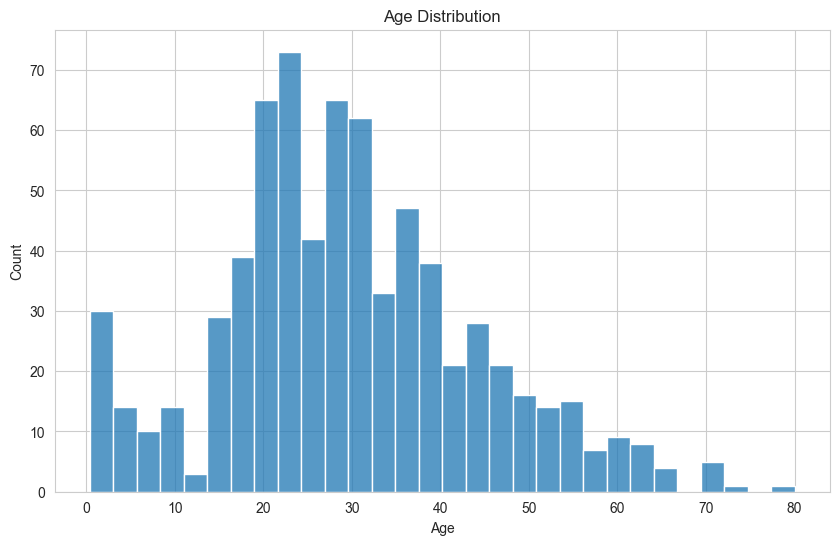

In [3]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(raw_data['Age'].dropna(), bins=30)
plt.title('Age Distribution')
plt.show()

Interesting to see so many children under 10 years old and that the majority of the passengers are in their 20's.

### Survival based on passenger class

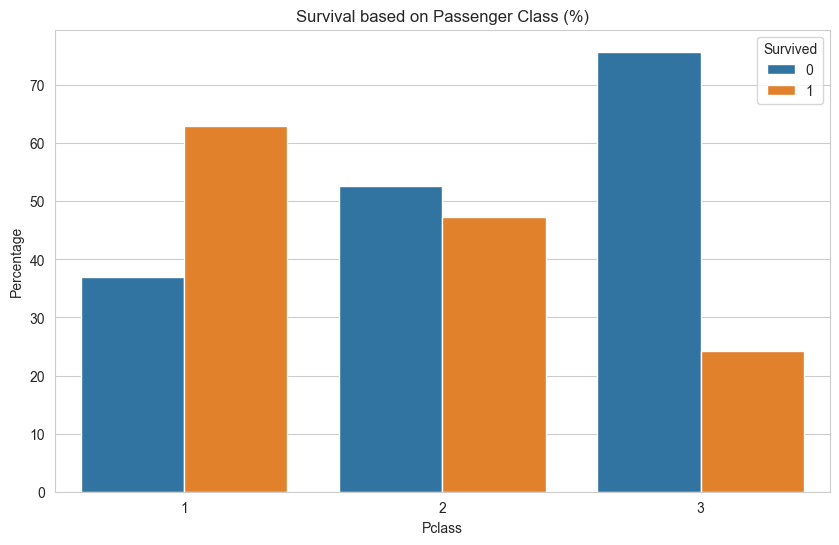

In [4]:
class_survival = raw_data.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack().fillna(0)
class_survival = class_survival.multiply(100)
class_survival.reset_index(inplace=True)
class_survival_long = class_survival.melt(id_vars='Pclass', value_vars=[0, 1], var_name='Survived', value_name='Percentage')

plt.figure(figsize=(10,6))
sns.barplot(x='Pclass', y='Percentage', hue='Survived', data=class_survival_long)
plt.title('Survival based on Passenger Class (%)')
plt.ylabel('Percentage')
plt.show()

We can see that first class had the highest survival rate over 60%. Second class with barely 50% survival and the third class with a close to only 25% survival.

A harsh really hits you when you realise that the rich people most likely got priority in the lifeboats.

### Survival based on gender


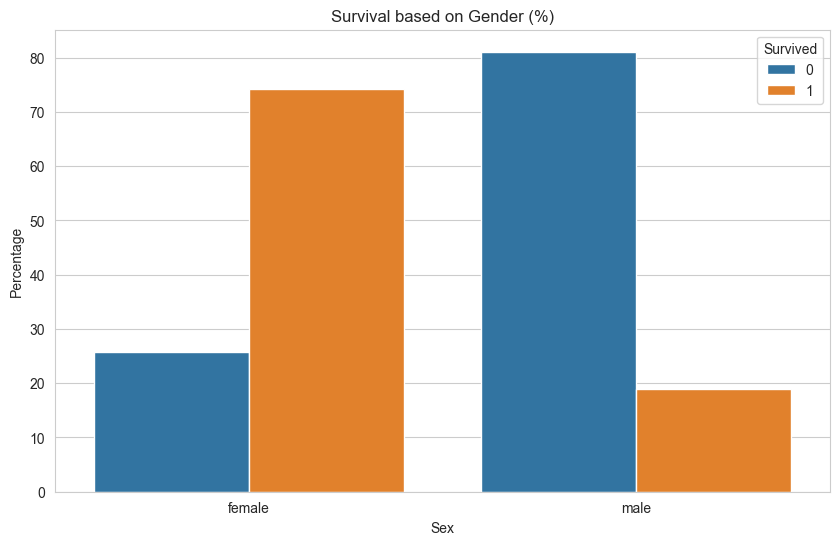

In [5]:
sex_survival = raw_data.groupby('Sex')['Survived'].value_counts(normalize=True).unstack().fillna(0)
sex_survival = sex_survival.multiply(100)
sex_survival.reset_index(inplace=True)
sex_survival_long = sex_survival.melt(id_vars='Sex', value_vars=[0, 1], var_name='Survived', value_name='Percentage')

plt.figure(figsize=(10,6))
sns.barplot(x='Sex', y='Percentage', hue='Survived', data=sex_survival_long)
plt.title('Survival based on Gender (%)')
plt.ylabel('Percentage')
plt.show()

It's not that surprising that woman had a high survival rate, as it's very commonly heard that woman and children are prioritized.

### Fare distribution


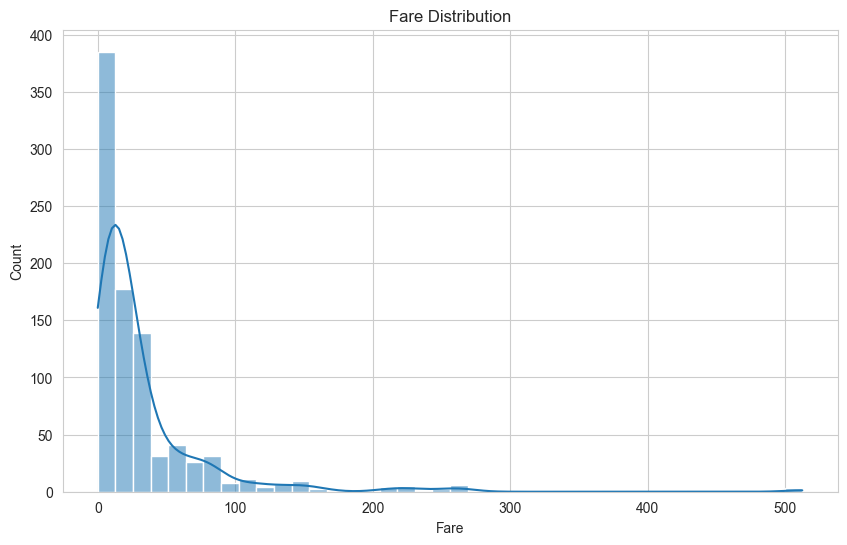

In [6]:
plt.figure(figsize=(10,6))
sns.histplot(raw_data['Fare'], bins=40, kde=True)
plt.title('Fare Distribution')
plt.show()

The majority of the passangers have the cheapest fare.

### Cabin Column

I want to check out the Cabin column, because it thought it was odd that there were so many null values.

In [7]:
print(raw_data['Cabin'].unique())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']


So the Cabin column this contains the deck letter and the actual room number. And it looks like some of the passangers some were residing in multiple rooms.
It could be that all the null values arent missing data point, but that the majority of the passangers actually didnt have a cabin.

But for now let's just get rid of this column.

## Data Preprocessing

### Making a copy of the raw data
I'm making a copy of the raw_data, so i can re-run this section of the notebook, just to make it easier for myself during testing & development.

In [8]:
data = raw_data.copy()

### Handling null values
I need to fill out the null values of the Embarked and Age column, then drop the Cabin column.

I am opting to use the most common value to fill out Embarked and using the median age value for the Age column.

In [9]:
data.drop(["Cabin"], axis=1, inplace=True, errors="ignore")
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Age'].fillna(data['Age'].median(), inplace=True)

### One-hot encoding

I'm encoding Sex into binary by converting female and male to 1s and 0s.

Thereafter, I'm transposing all the Embarked values to columns with a boolean value to mark which port the passanger embarked from.

In [10]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
embarked_dummies = pd.get_dummies(data['Embarked'], drop_first=True)
data = pd.concat([data, embarked_dummies], axis=1)
data.drop(['Embarked', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

### Normalizing the Age & Fare column
The age and fare is already numeric. But to normalize the data, I need to use a scaler, to squish the value inbetween 0-1.

In [11]:
data[['Age', 'Fare']] = StandardScaler().fit_transform(data[['Age', 'Fare']])

### Prepare train & test split

Splitting the dataset with a 80/20 split.

In [12]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

### Fitting the model

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Prediction and classification report

In [14]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



I get a 81% accuracy score, which is pretty good for just a simple logistic regression model.

I want to try and see if I can improve that score by using a Random Forest model.

## Random Forest

### Tuning the hyperparameter

For tuning I am passing in random values into the hyperparameters and using RandomizedSearchCV to save time on the fitting process.

In [15]:
model = RandomForestClassifier()

params ={'max_depth': st.randint(5, 10),
             'n_estimators':st.randint(250, 500),
             'max_features':np.arange(0.5, 0.75, 0.05),
             'max_leaf_nodes':st.randint(5, 10)}

grid = RandomizedSearchCV(model, params, cv=10, n_iter=20, scoring='accuracy', verbose=1)

grid.fit(X_train, y_train)

print("Best parameters: ", grid.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters:  {'max_depth': 6, 'max_features': 0.6000000000000001, 'max_leaf_nodes': 9, 'n_estimators': 306}


### Prediction and classification report

In [16]:
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



An accuracy score of 80%, seems quite underwhelming. I had hoped to see better results, which might be because of my tuning method.

## Cabin column revisited

I want to go back and look at the Cabin column. I want to see how a model would fare purely on that column alone.

### Isolating the Cabin column

In [17]:
cabin_data = raw_data[["Survived", "Cabin"]].copy()

display(cabin_data.head())

,Survived,Cabin
0,0,NaN
1,1,C85
2,1,NaN
3,1,C123
4,0,NaN


### Isolating the deck letter of the Cabin column

Based on how the rooms are places on a deck, could very much affect your ability to get to the lifeboats in time. The problem is I dont have enough room data for a model to make that correlation, but how about only using the deck letter.

Depending on the deck, it could provide an easier route for the lifeboats. So let's isolate the deck letter into its own column.

In [18]:
cabin_data["Deck"] = cabin_data["Cabin"].str.slice(0,1)
cabin_data.drop(["Cabin"], axis=1, inplace=True, errors="ignore")
cabin_data.head()

,Survived,Deck
0,0,NaN
1,1,C
2,1,NaN
3,1,C
4,0,NaN


### Handling null values

I need to deal with all those missing deck values. Since my assumption is that no value means you didnt have a cabin, Im will fill all null values with the letter Z to indicate a lower status.

In [19]:
cabin_data["Deck"] = cabin_data["Deck"].fillna("Z")
cabin_data.head()

,Survived,Deck
0,0,Z
1,1,C
2,1,Z
3,1,C
4,0,Z


### One-hot encoding
I need to encode the Deck into something that a model can understand. I will do this in a similar manner as how I one-hot encoded the Embarked column.

In [20]:
deck_dummies = pd.get_dummies(cabin_data['Deck'], prefix="Deck")
cabin_data.drop(["Deck"], axis=1, inplace=True, errors="ignore")
cabin_data = pd.concat([cabin_data, deck_dummies], axis=1)
cabin_data.head()

,Survived,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Z
0,0,False,False,False,False,False,False,False,False,True
1,1,False,False,True,False,False,False,False,False,False
2,1,False,False,False,False,False,False,False,False,True
3,1,False,False,True,False,False,False,False,False,False
4,0,False,False,False,False,False,False,False,False,True


### Model fitting

It's now time to test and see how well this model will fare using only the Deck as a feature.

In [21]:
cabin_X = cabin_data.drop('Survived', axis=1)
cabin_y = cabin_data['Survived']

cabin_X_train, cabin_X_test, cabin_y_train, cabin_y_test = train_test_split(cabin_X, cabin_y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(cabin_X_train, cabin_y_train)

LogisticRegression()

### Prediction and classification report

In [22]:
cabin_y_pred = model.predict(cabin_X_test)
print(classification_report(cabin_y_test, cabin_y_pred))

              precision    recall  f1-score   support

           0       0.68      0.90      0.78       105
           1       0.74      0.39      0.51        74

    accuracy                           0.69       179
   macro avg       0.71      0.65      0.64       179
weighted avg       0.71      0.69      0.67       179



An accuracy score of 69%. I'm quite happy about that result, given especially since it's a column with so many null values.

## Conclusion

I managed to get an accuracy score of 81% using a Logistic Regression model. The Random Forest model didnt fare as well, but I believe if I had used GridSearchCV for the hyperparameter tuning, I would very likely have scored a higher result.

I am also curious if my investigation into the cabin column could be integrated into my main model to enhance its accuracy. Although I didn't manage to get it working, my model would always only perform worse than the model without the cabin column.

By browsing the leaderboard on Kaggle, I can see that a score above 80% is pretty decent. Thus, I am very pleased with my result.

